In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M2_S1/amal/tme3

Mounted at /content/drive
/content/drive/MyDrive/M2_S1/amal/tme3


In [ ]:
!pip install tensorboard

In [21]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=d54efe1c333781fe5666f9e24b7ddaca5771c4e3b5539ee7dbb407403de22cfa
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [2]:
from pathlib import Path
import os
import pickle
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
import matplotlib.pyplot as plt
%load_ext tensorboard
# Téléchargement des données

#from datamaestro import prepare_dataset
##ds = prepare_dataset("com.lecun.mnist");
#train_images, train_labels = ds.train.images.data(), ds.train.labels.data()
#test_images, test_labels =  ds.test.images.data(), ds.test.labels.data()

# Tensorboard : rappel, lancer dans une console tensorboard --logdir runs
#writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Pour visualiser
# Les images doivent etre en format Channel (3) x Hauteur x Largeur
#images = torch.tensor(train_images).unsqueeze(1).repeat(1,3,1,1).double()/255.
# Permet de fabriquer une grille d'images
#images = make_grid(images)
# Affichage avec tensorboard
#writer.add_image(f'samples', images, 0)

#savepath = Path("model.pch")

with open('mnist', 'rb') as f: # je sauvegarde data sur mon ordi
    l = pickle.load(f)
train_images, train_labels = l[0], l[1]
test_images, test_labels = l[2], l[3]

## Créer Dataset

In [3]:
class monDataset(Dataset):
    def __init__(self, image, label):
        self.y = label
        self.sizeIMG = image.shape[-1]
        self.x = torch.tensor(image)/255.
        self.x = torch.reshape(self.x, (len(self.y), -1))
        self.x = self.x.to(torch.float32)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.y)

    def getDimIn(self):
        return self.x.shape[1]

    def getData(self):
        return self.x, self.y

    def getIMGsize(self):
        return self.sizeIMG

In [4]:
dstrain = monDataset(train_images, train_labels)
dstest = monDataset(test_images, test_labels)

## Visualisation de données

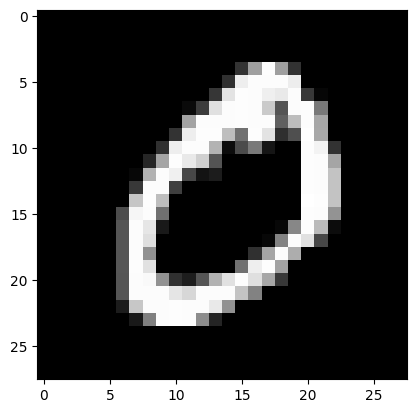

In [5]:
DIM_IN = dstrain.getDimIn()
ORIGIN_SIZE = dstrain.getIMGsize()
data_sample = dstrain[1]
x = data_sample[0].reshape(ORIGIN_SIZE,ORIGIN_SIZE)*255.
plt.imshow(x, cmap='gray')

## Créer Dataloader

In [6]:
data = DataLoader(dstrain, shuffle=True, batch_size=64)
data_test = DataLoader(dstest, shuffle=True, batch_size=100)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Autoencoder

In [77]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, dim_in, hidden):
        super().__init__()
        self.dim_in = dim_in
        self.hidden = hidden
        self.biasDecoder = torch.rand(self.dim_in, requires_grad=True, device=device)
        self.encoder = nn.Linear(self.dim_in, self.hidden)

    def forward(self, input):
        x = self.encoder(input)
        x = torch.relu(x)
        x = F.linear(x, self.encoder.weight.T, bias=self.biasDecoder)
        x = torch.sigmoid(x)
        return x

Intétêt d'utiliser un poid partagé pour l'encodeur et le décodeur: nous pourrions le considérer comme une façon de régularisation, ceci réduit la compléxité du réseau.

## Check point

In [8]:
class State :
    def __init__ (self, model, optim):
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0, 0

In [81]:
savepath = Path("model.plt")
DIM_IN = dstrain.getDimIn()
HIDDEN = 40
lr = 0.5
NB_EPOCH = 20
if savepath.is_file():
    with savepath.open("rb") as fp :
        state = torch.load(fp)
else:
    model = AutoEncoder(DIM_IN, HIDDEN).to(device)
    optim = torch.optim.SGD(params=[model.encoder.weight, model.encoder.bias, model.biasDecoder],lr=lr)
    state = State(model, optim)

loss = torch.nn.BCELoss()

## Training

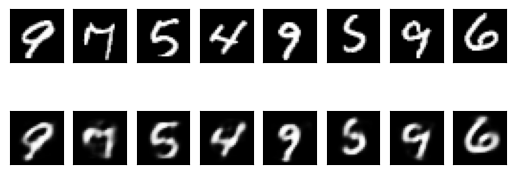

In [89]:
writer = SummaryWriter()
for epoch in range(state.epoch, NB_EPOCH):
    print(f'Epoch {epoch+1}')

    for x, y in data:
        x = x.to(device)
        x_reconstruction = state.model.forward(x)
        state.optim.zero_grad()
        l = loss(x_reconstruction, x)
        l.backward()
        state.optim.step()
        state.iteration += 1
        writer.add_scalar('Loss/train', l, state.iteration)

    with savepath.open("wb") as fp :
        state.epoch = epoch + 1
        torch.save(state, fp)

    with torch.no_grad():
        x_test,y_test = next(iter(data_test))
        x_test = x_test.to(device)
        writer.add_scalar('Loss/test', loss(state.model.forward(x_test), x_test), state.iteration)

fig, axs = plt.subplots(nrows=2, ncols=8, subplot_kw={'xticks': [], 'yticks': []})
NB_IMG = 8
img_original = np.zeros((NB_IMG,ORIGIN_SIZE, ORIGIN_SIZE))
img_reconstruite = np.zeros((NB_IMG,ORIGIN_SIZE, ORIGIN_SIZE))
for x,y in data:
    x = x.to(device)
    xhat = state.model.forward(x)
    for i in range(NB_IMG):
      img_original[i] = (x[i].cpu().detach().numpy().reshape((ORIGIN_SIZE, ORIGIN_SIZE)) * 255.).astype(int)
      img_reconstruite[i] = (xhat[i].cpu().detach().numpy().reshape((ORIGIN_SIZE, ORIGIN_SIZE)) * 255.).astype(int)
      axs[0, i].imshow(img_original[i], cmap='gray')
      axs[1, i].imshow(img_reconstruite[i], cmap='gray')
    break

plt.subplots_adjust(top = 0.5)
plt.show()

writer.close()

In [94]:
%tensorboard --logdir=runs  --host localhost

<IPython.core.display.Javascript object>

## Muti couches latentes

In [103]:
class AutoEncoder2(torch.nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.dim_in = dim_in
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(self.dim_in, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.dim_in),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        x = self.seq(input)
        return x

In [104]:
savepath = Path("model_2.plt")
DIM_IN = dstrain.getDimIn()
lr = 0.1
NB_EPOCH = 20
if savepath.is_file():
    with savepath.open("rb") as fp :
        state = torch.load(fp)
else:
    model = AutoEncoder2(DIM_IN).to(device)
    optim = torch.optim.SGD(params=model.parameters(),lr=lr)
    state = State(model, optim)

loss = torch.nn.BCELoss()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


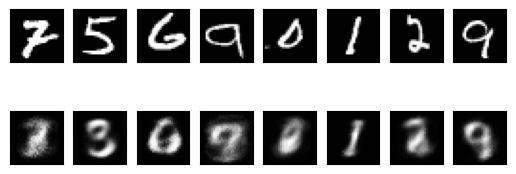

In [105]:
writer = SummaryWriter()
for epoch in range(state.epoch, NB_EPOCH):
    print(f'Epoch {epoch+1}')

    for x, y in data:
        x = x.to(device)
        x_reconstruction = state.model.forward(x)
        state.optim.zero_grad()
        l = loss(x_reconstruction, x)
        l.backward()
        state.optim.step()
        state.iteration += 1
        writer.add_scalar('Loss/train', l, state.iteration)

    with savepath.open("wb") as fp :
        state.epoch = epoch + 1
        torch.save(state, fp)

    with torch.no_grad():
        x_test,y_test = next(iter(data_test))
        x_test = x_test.to(device)
        writer.add_scalar('Loss/test', loss(state.model.forward(x_test), x_test), state.iteration)

fig, axs = plt.subplots(nrows=2, ncols=8, subplot_kw={'xticks': [], 'yticks': []})
NB_IMG = 8
img_original = np.zeros((NB_IMG,ORIGIN_SIZE, ORIGIN_SIZE))
img_reconstruite = np.zeros((NB_IMG,ORIGIN_SIZE, ORIGIN_SIZE))
for x,y in data:
    x = x.to(device)
    xhat = state.model.forward(x)
    for i in range(NB_IMG):
      img_original[i] = (x[i].cpu().detach().numpy().reshape((ORIGIN_SIZE, ORIGIN_SIZE)) * 255.).astype(int)
      img_reconstruite[i] = (xhat[i].cpu().detach().numpy().reshape((ORIGIN_SIZE, ORIGIN_SIZE)) * 255.).astype(int)
      axs[0, i].imshow(img_original[i], cmap='gray')
      axs[1, i].imshow(img_reconstruite[i], cmap='gray')
    break

plt.subplots_adjust(top = 0.5)
plt.show()

writer.close()

## Highway network

In [9]:
class HighwayToHeaven(torch.nn.Module):
  def __init__(self, dim_in, nb_couches):
    super().__init__()
    self.nb_couches = nb_couches
    self.H = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_in) for i in range(self.nb_couches)])
    self.activation_H = torch.nn.ReLU() # or tanh
    self.T = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_in) for i in range(self.nb_couches)])
    self.activation_T = torch.nn.Sigmoid() # transform gate article utilise sigmoide
    # In our experiments, we found that a negative bias initialization was sufficient for learning (article)
    for gate in self.T:
      gate.bias.data.fill_(-1)

  def forward(self, input):
    x = input
    for i in range(self.nb_couches):
      # H
      x_ = x
      h = self.H[i](x)
      h = self.activation_H(h)

      # T
      t = self.T[i](x)
      t = self.activation_T(t)

      x = h*t + x_*(1-t)
    return x


In [11]:
savepath = Path("model_hw.plt")
DIM_IN = dstrain.getDimIn()
NB_COUCHES = 2
lr = 0.1
NB_EPOCH = 20
if savepath.is_file():
    with savepath.open("rb") as fp :
        state = torch.load(fp)
else:
    model = HighwayToHeaven(DIM_IN, NB_COUCHES).to(device)
    optim = torch.optim.SGD(params=model.parameters(),lr=lr)
    state = State(model, optim)

loss = torch.nn.BCEWithLogitsLoss()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


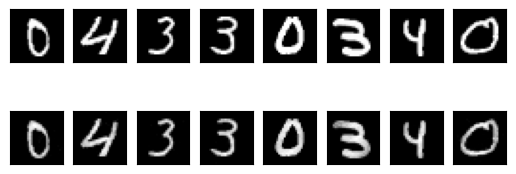

In [12]:
writer = SummaryWriter()
for epoch in range(state.epoch, NB_EPOCH):
    print(f'Epoch {epoch+1}')

    for x, y in data:
        x = x.to(device)
        x_reconstruction = state.model.forward(x)
        state.optim.zero_grad()
        l = loss(x_reconstruction, x)
        l.backward()
        state.optim.step()
        state.iteration += 1
        writer.add_scalar('Loss/train', l, state.iteration)

    with savepath.open("wb") as fp :
        state.epoch = epoch + 1
        torch.save(state, fp)

    with torch.no_grad():
        x_test,y_test = next(iter(data_test))
        x_test = x_test.to(device)
        writer.add_scalar('Loss/test', loss(state.model.forward(x_test), x_test), state.iteration)

fig, axs = plt.subplots(nrows=2, ncols=8, subplot_kw={'xticks': [], 'yticks': []})
NB_IMG = 8
img_original = np.zeros((NB_IMG,ORIGIN_SIZE, ORIGIN_SIZE))
img_reconstruite = np.zeros((NB_IMG,ORIGIN_SIZE, ORIGIN_SIZE))
for x,y in data:
    x = x.to(device)
    xhat = state.model.forward(x)
    for i in range(NB_IMG):
      img_original[i] = (x[i].cpu().detach().numpy().reshape((ORIGIN_SIZE, ORIGIN_SIZE)) * 255.).astype(int)
      img_reconstruite[i] = (xhat[i].cpu().detach().numpy().reshape((ORIGIN_SIZE, ORIGIN_SIZE)) * 255.).astype(int)
      axs[0, i].imshow(img_original[i], cmap='gray')
      axs[1, i].imshow(img_reconstruite[i], cmap='gray')
    break

plt.subplots_adjust(top = 0.5)
plt.show()

writer.close()

Comparaison: Highway réseau reconstruit bien les données MNIST. Pour 20 epochs, avec le même learning rate, les données reconstruites d'un réseau de 4 couches (dont 2 couches latents) sont moins bonnes que HW réseau. Et pour le réseau poid partagé, il faut avoir un pas de learning rate assez grand $0.5$ pour avoir des résultats aussi bons que HW réseau.